In [2]:
#import relevant libraries
import requests
from config import api_key
import json
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
#URLs
business_owner_url = f'https://api.census.gov/data/2018/abscbo?get=GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,OWNER_SEX,OWNER_SEX_LABEL,OWNER_ETH,OWNER_ETH_LABEL,OWNER_RACE,OWNER_RACE_LABEL,OWNER_VET,OWNER_VET_LABEL,QDESC,QDESC_LABEL,OWNCHAR,OWNCHAR_LABEL,YEAR,OWNPDEMP,OWNPDEMP_F,OWNPDEMP_PCT,OWNPDEMP_PCT_F,OWNPDEMP_S,OWNPDEMP_S_F,OWNPDEMP_PCT_S,OWNPDEMP_PCT_S_F&for=us:*&for=QDESC_LABEL=ACQBUS&key={api_key}'

business_characteristics_url = f'https://api.census.gov/data/2018/abscb?get=GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,SEX,SEX_LABEL,ETH_GROUP,ETH_GROUP_LABEL,RACE_GROUP,RACE_GROUP_LABEL,VET_GROUP,VET_GROUP_LABEL,QDESC,QDESC_LABEL,BUSCHAR,BUSCHAR_LABEL,YEAR,FIRMPDEMP,FIRMPDEMP_F,FIRMPDEMP_PCT,FIRMPDEMP_PCT_F,RCPPDEMP,RCPPDEMP_F,RCPPDEMP_PCT,RCPPDEMP_PCT_F,EMP,EMP_F,EMP_PCT,EMP_PCT_F,PAYANN,PAYANN_F,PAYANN_PCT,PAYANN_PCT_F,FIRMPDEMP_S,FIRMPDEMP_S_F,FIRMPDEMP_PCT_S,FIRMPDEMP_PCT_S_F,RCPPDEMP_S,RCPPDEMP_S_F,RCPPDEMP_PCT_S,RCPPDEMP_PCT_S_F,EMP_S,EMP_S_F,EMP_PCT_S,EMP_PCT_S_F,PAYANN_S,PAYANN_S_F,PAYANN_PCT_S,PAYANN_PCT_S_F&for=us:*&for=QDESC_LABEL=SPOUSES&key={api_key}'

company_summary_url = f'https://api.census.gov/data/2018/abscs?get=GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,SEX,SEX_LABEL,ETH_GROUP,ETH_GROUP_LABEL,RACE_GROUP,RACE_GROUP_LABEL,VET_GROUP,VET_GROUP_LABEL,EMPSZFI,EMPSZFI_LABEL,YEAR,FIRMPDEMP,FIRMPDEMP_F,RCPPDEMP,RCPPDEMP_F,EMP,EMP_F,PAYANN,PAYANN_F,FIRMPDEMP_S,FIRMPDEMP_S_F,RCPPDEMP_S,RCPPDEMP_S_F,EMP_S,EMP_S_F,PAYANN_S,PAYANN_S_F&for=us:*&key={api_key}'

In [4]:
def API2DataFrame(url):
    '''
    url: str
    
    takes in url for API and returns a pandas DataFrame
    '''
    #Gather data from the API
    response = requests.get(url)
    #Load data into DataFrame
    df = pd.DataFrame(response.json())
    #Grab the first row for the header
    new_header = df.iloc[0]
    #Take the data other than the header row
    df = df[1:]
    #Set the header row as the df header
    df.columns = new_header
    #Append DataFrame to the data_frames list
    return df

In [5]:
#DataFrames
business_owner_characteristics = API2DataFrame(business_owner_url)

business_characteristics = API2DataFrame(business_characteristics_url)

company_summary = API2DataFrame(company_summary_url)

In [6]:
def cleanDataFrame(dataframe, drop_columns = [], filter_columns = []):
    '''
    dataframe: a pandas DataFrame
    drop_columns: list of columns to be dropped from dataframe
    filter_columns: list of columns that act as filter/flags for the record
    
    Takes in a pandas dataframe and drops unwanted columns and cleans data according to flag/filters
    '''
    
    #Remove unwanted columns
    dataframe = dataframe.drop(columns = drop_columns)
    
    #Remove all columns and rows that have all null values
    dataframe.dropna(axis='columns', how='all',inplace=True)
    dataframe.dropna(axis='rows', how='all',inplace=True)
    
    #Remove all records where there is a flag
    for column in filter_columns:
        #Remove records for one flag at a time
        dataframe.drop(dataframe.loc[dataframe[column] == 'D'].index, inplace=True)
        
    #After filtering flags, we can remove flag columns
    dataframe.drop(columns = filter_columns, inplace = True)
    
    
    return dataframe

In [7]:
# For each data frame, we'll want to drop specific columns
# Business owner characteristics: GEO_ID, NAICS2017, OWNER_SEX, OWNER_ETH, OWNER_RACE, OWNER_VET, QDESC, OWNCHAR, YEAR, state
drop_columns = ['GEO_ID', 'NAICS2017', 'OWNER_SEX', 'OWNER_ETH', 'OWNER_RACE',
                'OWNER_VET', 'QDESC', 'QDESC_LABEL', 'OWNCHAR', 'YEAR', 'us']

flag_columns = ['OWNPDEMP_F', 'OWNPDEMP_PCT_F', 'OWNPDEMP_S_F', 'OWNPDEMP_PCT_S_F']

business_owner_characteristics = cleanDataFrame(business_owner_characteristics, drop_columns = drop_columns, filter_columns = flag_columns)

In [8]:
business_owner_characteristics['OWNPDEMP_PCT'] = business_owner_characteristics['OWNPDEMP_PCT'].astype(float)
business_owner_characteristics['OWNPDEMP_S'] = business_owner_characteristics['OWNPDEMP_S'].astype(float)
business_owner_characteristics['OWNPDEMP_PCT_S'] = business_owner_characteristics['OWNPDEMP_PCT_S'].astype(float)

In [9]:
# For each data frame, we'll want to drop specific columns
# Business characteristics: GEO_ID, NAICS2017, SEX, ETH_GROUP, RACE_GROUP, VET_GROUP, QDESC, BUSCHAR, YEAR, us
drop_columns = ['GEO_ID', 'NAICS2017', 'SEX', 'ETH_GROUP', 'RACE_GROUP', 'VET_GROUP', 'QDESC', 'BUSCHAR', 'YEAR', 'us']
flag_columns = ['FIRMPDEMP_F', 'FIRMPDEMP_PCT_F', 'RCPPDEMP_F', 'RCPPDEMP_PCT_F', 'EMP_F', 'EMP_PCT_F', 'PAYANN_F',
                'PAYANN_PCT_F', 'FIRMPDEMP_S_F', 'FIRMPDEMP_PCT_S_F', 'RCPPDEMP_S_F', 'RCPPDEMP_PCT_S_F', 'EMP_S_F',
                'EMP_PCT_S_F', 'PAYANN_S_F', 'PAYANN_PCT_S_F']

business_characteristics = cleanDataFrame(business_characteristics, drop_columns = drop_columns, filter_columns = flag_columns)

In [10]:
# For each data frame, we'll want to drop specific columns
# company summary: GEO_ID, NAICS2017, SEX, ETH_GROUP, RACE_GROUP, VET_GROUP, EMPSZFI, YEAR, us
drop_columns = ['GEO_ID', 'NAICS2017', 'SEX', 'ETH_GROUP', 'RACE_GROUP', 'VET_GROUP', 'EMPSZFI', 'YEAR', 'us']
flag_columns = ['FIRMPDEMP_F', 'RCPPDEMP_F', 'EMP_F', 'PAYANN_F', 'FIRMPDEMP_S_F', 'RCPPDEMP_S_F', 'EMP_S_F', 'PAYANN_S_F']

company_summary = cleanDataFrame(company_summary, drop_columns = drop_columns, filter_columns = flag_columns)

Everything prior to this markdown block is from the cleaned data file in the GitHub

1. In this next code block, I only took the columns I needed. Then I filtered out all rows that were not the top 5 sectors based on number of employees.

2. Filter out all rows except for the "All firms" rows and the 5 races rows (White, Black, Asian, Native, Pacific Islander). The I sorted by the sector column.

In [11]:
# 1
cSum = company_summary[['NAICS2017_LABEL','SEX_LABEL','ETH_GROUP_LABEL','RACE_GROUP_LABEL','VET_GROUP_LABEL','EMPSZFI_LABEL','FIRMPDEMP','EMP']]

cSum1 = cSum[(cSum['NAICS2017_LABEL'] == 'Health care and social assistance')
|(cSum['NAICS2017_LABEL'] == 'Retail trade')
|(cSum['NAICS2017_LABEL'] == 'Accommodation and food services')
|(cSum['NAICS2017_LABEL'] == 'Administrative and support and waste management and remediation services')
|(cSum['NAICS2017_LABEL'] == 'Manufacturing')]

# 2
summary = cSum1[(cSum1['EMPSZFI_LABEL'] == 'All firms')
&(cSum1['SEX_LABEL'] == 'Total')
&(cSum1['ETH_GROUP_LABEL'] == 'Total')
&(cSum1['RACE_GROUP_LABEL'] != 'Total')
&(cSum1['RACE_GROUP_LABEL'] != 'Minority')
&(cSum1['RACE_GROUP_LABEL'] != 'Equally minority/nonminority')
&(cSum1['RACE_GROUP_LABEL'] != 'Nonminority')
&(cSum1['VET_GROUP_LABEL'] == 'Total')]

summary.sort_values(by='NAICS2017_LABEL',inplace=True)

C:\Users\temes\AppData\Local\Temp\ipykernel_12472\3172849939.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary.sort_values(by='NAICS2017_LABEL',inplace=True)


I changed the number of employees column datatype to integer

In [12]:
graph = summary[['NAICS2017_LABEL','RACE_GROUP_LABEL']]
graph['EMP_Num'] = summary['EMP'].astype(int)

C:\Users\temes\AppData\Local\Temp\ipykernel_12472\958857723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph['EMP_Num'] = summary['EMP'].astype(int)


Created a dataframe for each individual race, which had the number of employees for each of the top 5 sectors, and added a percent of total column by dividing the sum of all employees by the number of employees for each sector, and it multiplied by 100.

In [13]:
gWhite = graph[graph['RACE_GROUP_LABEL'] == 'White']
total = gWhite['EMP_Num'].sum()
gWhite['Perc_of_Total'] = (gWhite['EMP_Num']/total)*100

gBlack = graph[graph['RACE_GROUP_LABEL'] == 'Black or African American']
total = gBlack['EMP_Num'].sum()
gBlack['Perc_of_Total'] = (gBlack['EMP_Num']/total)*100

gAsian = graph[graph['RACE_GROUP_LABEL'] == 'Asian']
total = gAsian['EMP_Num'].sum()
gAsian['Perc_of_Total'] = (gAsian['EMP_Num']/total)*100

gNative = graph[graph['RACE_GROUP_LABEL'] == 'American Indian and Alaska Native']
total = gNative['EMP_Num'].sum()
gNative['Perc_of_Total'] = (gNative['EMP_Num']/total)*100

gPacific = graph[graph['RACE_GROUP_LABEL'] == 'Native Hawaiian and Other Pacific Islander']
total = gPacific['EMP_Num'].sum()
gPacific['Perc_of_Total'] = (gPacific['EMP_Num']/total)*100

C:\Users\temes\AppData\Local\Temp\ipykernel_12472\1329895247.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gWhite['Perc_of_Total'] = (gWhite['EMP_Num']/total)*100
C:\Users\temes\AppData\Local\Temp\ipykernel_12472\1329895247.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gBlack['Perc_of_Total'] = (gBlack['EMP_Num']/total)*100
C:\Users\temes\AppData\Local\Temp\ipykernel_12472\1329895247.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

Created Chart5

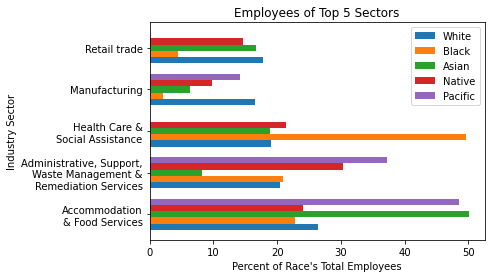

In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

labels = ['Accommodation\n& Food Services', 'Administrative, Support,\nWaste Management &\nRemediation Services', 'Health Care &\nSocial Assistance', 'Manufacturing', 'Retail trade']

x = np.arange(len(labels))
width = 0.15

fig, ax = plt.subplots()
rects1 = ax.barh(x - width*2, gWhite['Perc_of_Total'], width, label='White')
rects2 = ax.barh(x - width, gBlack['Perc_of_Total'], width, label='Black')
rects3 = ax.barh(x, gAsian['Perc_of_Total'], width, label='Asian')
rects4 = ax.barh(x + width, gNative['Perc_of_Total'], width, label='Native')
rects5 = ax.barh(x + width*2, gPacific['Perc_of_Total'], width, label='Pacific')

ax.set_ylabel('Industry Sector')
ax.set_xlabel('Percent of Race\'s Total Employees')
ax.set_title('Employees of Top 5 Sectors')
ax.set_yticks(x, labels)
ax.legend()

plt.show()

This is the list of the top 10 industry sectors with it's total number of employees. I deleted the code that got me this result, it was taking up space and I didn't think it was really necessary.

In [15]:
# 1. 'Health care and social assistance' ---------------------------------------- 19,123,446
# 2. 'Retail trade' ------------------------------------------------------------- 15,875,876
# 3. 'Accommodation and food services' ------------------------------------------ 14,275,081
# 4. 'Administrative and support and waste management and remediation services' - 12,694,998
# 5. 'Manufacturing' ------------------------------------------------------------ 12,006,094
# 6. 'Professional, scientific, and technical services' -------------------------  9,356,647
# 7. 'Construction' -------------------------------------------------------------  6,754,898
# 8. 'Finance and insurance' ----------------------------------------------------  6,643,953
# 9. 'Wholesale trade' ----------------------------------------------------------  6,109,303
#10. 'Transportation and warehousing' -------------------------------------------  5,049,216

1. Took only necessary columns, then filtered out all rows that were not the top 10 sectors based on number of employees.

2. Filter out all rows except for the "All firms" rows and the 5 races rows (White, Black, Asian, Native, Pacific Islander).

In [16]:
# 1
c_Sum = company_summary[['NAICS2017_LABEL','SEX_LABEL','ETH_GROUP_LABEL','RACE_GROUP_LABEL','VET_GROUP_LABEL','EMPSZFI_LABEL','FIRMPDEMP','EMP']]

c_Sum1 = c_Sum[(c_Sum['NAICS2017_LABEL'] == 'Health care and social assistance')
|(c_Sum['NAICS2017_LABEL'] == 'Retail trade')
|(c_Sum['NAICS2017_LABEL'] == 'Accommodation and food services')
|(c_Sum['NAICS2017_LABEL'] == 'Administrative and support and waste management and remediation services')
|(c_Sum['NAICS2017_LABEL'] == 'Manufacturing')
|(c_Sum['NAICS2017_LABEL'] == 'Professional, scientific, and technical services')
|(c_Sum['NAICS2017_LABEL'] == 'Construction')
|(c_Sum['NAICS2017_LABEL'] == 'Finance and insurance')
|(c_Sum['NAICS2017_LABEL'] == 'Wholesale trade')
|(c_Sum['NAICS2017_LABEL'] == 'Transportation and warehousing')]

# 2
summary = c_Sum1[(c_Sum1['EMPSZFI_LABEL'] == 'All firms')
&(c_Sum1['SEX_LABEL'] == 'Total')
&(c_Sum1['ETH_GROUP_LABEL'] == 'Total')
&(c_Sum1['RACE_GROUP_LABEL'] != 'Total')
&(c_Sum1['RACE_GROUP_LABEL'] != 'Minority')
&(c_Sum1['RACE_GROUP_LABEL'] != 'Equally minority/nonminority')
&(c_Sum1['RACE_GROUP_LABEL'] != 'Nonminority')
&(c_Sum1['VET_GROUP_LABEL'] == 'Total')]

Copied the sector and race columns into a new data frame, then changed the number of employees column datatype to integer and copied it to the new data frame

In [17]:
graph = summary[['NAICS2017_LABEL','RACE_GROUP_LABEL']]
graph['EMP_Num'] = summary['EMP'].astype(int)

C:\Users\temes\AppData\Local\Temp\ipykernel_12472\958857723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph['EMP_Num'] = summary['EMP'].astype(int)


Did the same thing I did earlier

In [18]:
gWhite = graph[graph['RACE_GROUP_LABEL'] == 'White']
total = gWhite['EMP_Num'].sum()
gWhite['Perc_of_Total'] = (gWhite['EMP_Num']/total)*100
gWhite.sort_values(by='Perc_of_Total',inplace=True)

gBlack = graph[graph['RACE_GROUP_LABEL'] == 'Black or African American']
total = gBlack['EMP_Num'].sum()
gBlack['Perc_of_Total'] = (gBlack['EMP_Num']/total)*100
gBlack.sort_values(by='Perc_of_Total',inplace=True)

gAsian = graph[graph['RACE_GROUP_LABEL'] == 'Asian']
total = gAsian['EMP_Num'].sum()
gAsian['Perc_of_Total'] = (gAsian['EMP_Num']/total)*100
gAsian.sort_values(by='Perc_of_Total',inplace=True)

gNative = graph[graph['RACE_GROUP_LABEL'] == 'American Indian and Alaska Native']
total = gNative['EMP_Num'].sum()
gNative['Perc_of_Total'] = (gNative['EMP_Num']/total)*100
gNative.sort_values(by='Perc_of_Total',inplace=True)

gPacific = graph[graph['RACE_GROUP_LABEL'] == 'Native Hawaiian and Other Pacific Islander']
total = gPacific['EMP_Num'].sum()
gPacific['Perc_of_Total'] = (gPacific['EMP_Num']/total)*100
gPacific.sort_values(by='Perc_of_Total',inplace=True)

C:\Users\temes\AppData\Local\Temp\ipykernel_12472\3896073250.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gWhite['Perc_of_Total'] = (gWhite['EMP_Num']/total)*100
C:\Users\temes\AppData\Local\Temp\ipykernel_12472\3896073250.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gWhite.sort_values(by='Perc_of_Total',inplace=True)
C:\Users\temes\AppData\Local\Temp\ipykernel_12472\3896073250.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Created Chart6

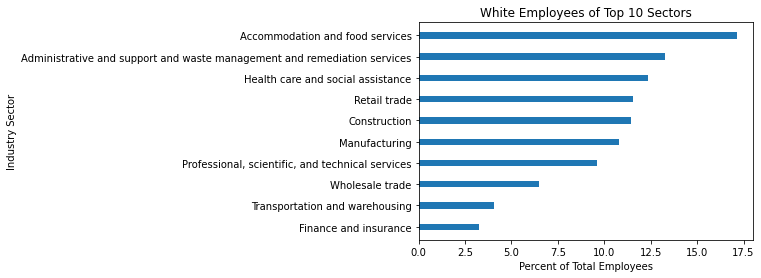

In [19]:
labels = gWhite['NAICS2017_LABEL']

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
rects1 = ax.barh(x, gWhite['Perc_of_Total'], width)

ax.set_ylabel('Industry Sector')
ax.set_xlabel('Percent of Total Employees')
ax.set_title('White Employees of Top 10 Sectors')
ax.set_yticks(x, labels)

plt.show()

Created Chart7

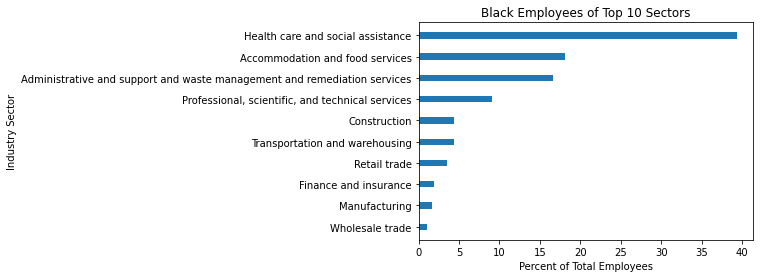

In [20]:
labels = gBlack['NAICS2017_LABEL']

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
rects1 = ax.barh(x, gBlack['Perc_of_Total'], width)

ax.set_ylabel('Industry Sector')
ax.set_xlabel('Percent of Total Employees')
ax.set_title('Black Employees of Top 10 Sectors')
ax.set_yticks(x, labels)

plt.show()

Created Chart8

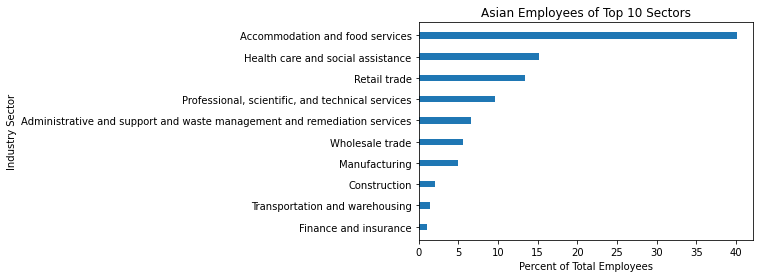

In [21]:
labels = gAsian['NAICS2017_LABEL']

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
rects1 = ax.barh(x, gAsian['Perc_of_Total'], width)

ax.set_ylabel('Industry Sector')
ax.set_xlabel('Percent of Total Employees')
ax.set_title('Asian Employees of Top 10 Sectors')
ax.set_yticks(x, labels)

plt.show()

Created Chart9

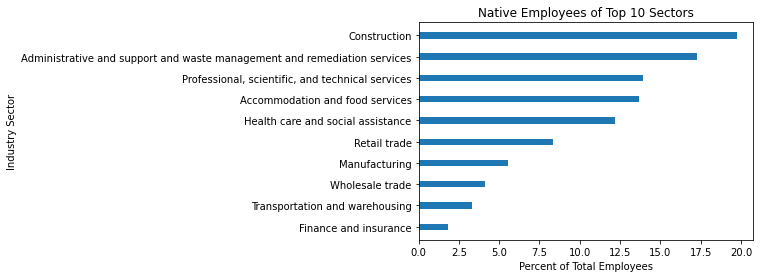

In [22]:
labels = gNative['NAICS2017_LABEL']

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
rects1 = ax.barh(x, gNative['Perc_of_Total'], width)

ax.set_ylabel('Industry Sector')
ax.set_xlabel('Percent of Total Employees')
ax.set_title('Native Employees of Top 10 Sectors')
ax.set_yticks(x, labels)

plt.show()

Created Chart10

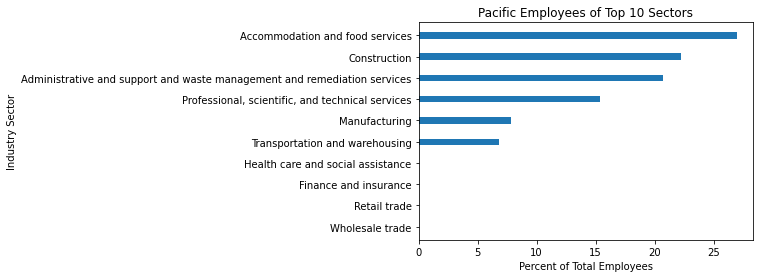

In [23]:
labels = gPacific['NAICS2017_LABEL']

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
rects1 = ax.barh(x, gPacific['Perc_of_Total'], width)

ax.set_ylabel('Industry Sector')
ax.set_xlabel('Percent of Total Employees')
ax.set_title('Pacific Employees of Top 10 Sectors')
ax.set_yticks(x, labels)

plt.show()